CAR ENGINE SYNTHESIS USING PHYSICAL MODELLING

Car engine audio is a complex conglomeration of many individual sounds of an engine. The main sources of engine audio are the cylinders of the engine and the exhaust system. The number of cylinders that an engine has is the main source for the difference in sounds between engines. An average vehicle will have four cylinders, each containing a piston that moves via a rotating crankshaft whose rotation phase is offset from the other crankshafts to allow for smoother movement of the car. 

A typical four-stroke engine uses four up and down movements of a piston in one cycle to work the engine. The cyle is as follows: (1) the fuel valve opens and the piston moves down, drawing air and fuel into the chamber, (2) the fuel valve closes and the piston moves upwards, compressing the air and fuel, (3) a spark ignites the mixture and the piston is forced downwards from the explosion, and (4) the exhaust valve opens and the piston moves upwards, pushing the exhaust out of the chamber. 

A two-stroke engine uses two up and down movements of a piston in one cycle. The cycle is as follows: (1) the fuel valve opens and pushes air and fuel into the chamber and the piston rises, compressing the mixture, and (2) a spark ignites and the piston is pushed downwards as the exhaust valve opens and exhaust is pushed out of the chamber.

The fuel and air mixture during these cycles can vary slightly with every cycle and the ignition timing mary also vary depending on electromechanical feedback. These variations can cause imperfections in the engine audio, creating sputters and jitters. 

When designing car engine audio, all of these elements must be taken into consideration to produce an accurate sound. This can be done with physical modelling using the physical traits of how an engine works to produce angine audio.

This notebook is an implementation of car engine audio via physical modelling. The code is based off a PureData implementation from Designing Sound by Andy Farnell, which I first converted to and got running in MaxMSP.

**The naming conventions for the variables in the Python code come from the PureData objects**

IMPORTS:

In [ ]:
import scipy.io.wavfile as wav
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plot
from scipy import signal 
import random

In [ ]:
# from https://github.com/gtzan/synthesizers_cs_perspective/blob/main/src/notebooks/digital_filters.ipynb
def band_pass(audio, freq, q, srate): 
    b = np.zeros(3)
    a = np.zeros(3)
    # center frequency in radians 
    frad = 2 * np.pi * freq / srate 
    # bandpass formulas 
    alpha_ = np.sin(frad)/(2*q)
    b[0] = np.sin(frad)/2
    b[1] =  0
    b[2] = -np.sin(frad)/2
    a[0] = 1 + alpha_
    a[1] = -2 * np.cos(frad) 
    a[2] = 1 - alpha_
    # apply filter once
    filtered_audio = signal.lfilter(b, a, audio)
    return filtered_audio 

def lo_pass(audio, cutoff, srate):
    nyq = 0.5 * srate
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(3, normal_cutoff, btype='lowpass', analog=False)
    return signal.lfilter(b, a, data)

def hi_pass(audio, cutoff, srate):
    nyq = 0.5 * srate
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(3, normal_cutoff, btype="high", analog=False)
    return signal.lfilter(b, a, audio)


HELPERS:

In [ ]:
# from https://github.com/gtzan/synthesizers_cs_perspective/blob/main/src/notebooks/sines_synthcsp.ipynb
def sinusoid(freq=440.0, dur=1.0, srate=44100.0, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data 
    

TOY ENGINE:
    
I first converted Farnell's simple toy engine over into MaxMSP and then into Python. I made a few changes to translate it over to MaxMSP. Firstly, I removed the 'break' reference at the top of the patch in PureData. I could not find reference to 'break' and therefore could not determine the values that were being multiplied by for the two * functions connecting the first noise audio and the sine wave at 9Hz, so I removed those as well and instead connected straight to the * 600 function. I also changed the * 600 function by removing the 600 multiplier, because, since the 'break' reference was removed, the right input using the 9Hz sine wave will never be blank and that 600 mulitplier will never be used based on the documentation for * for PureData that states that if there is audio connected in the right and left inputs then those audio inputs will be multiplied together and the value passed in will be ignored. Below is the PureData code and the MaxMSP code. 

Puredata:

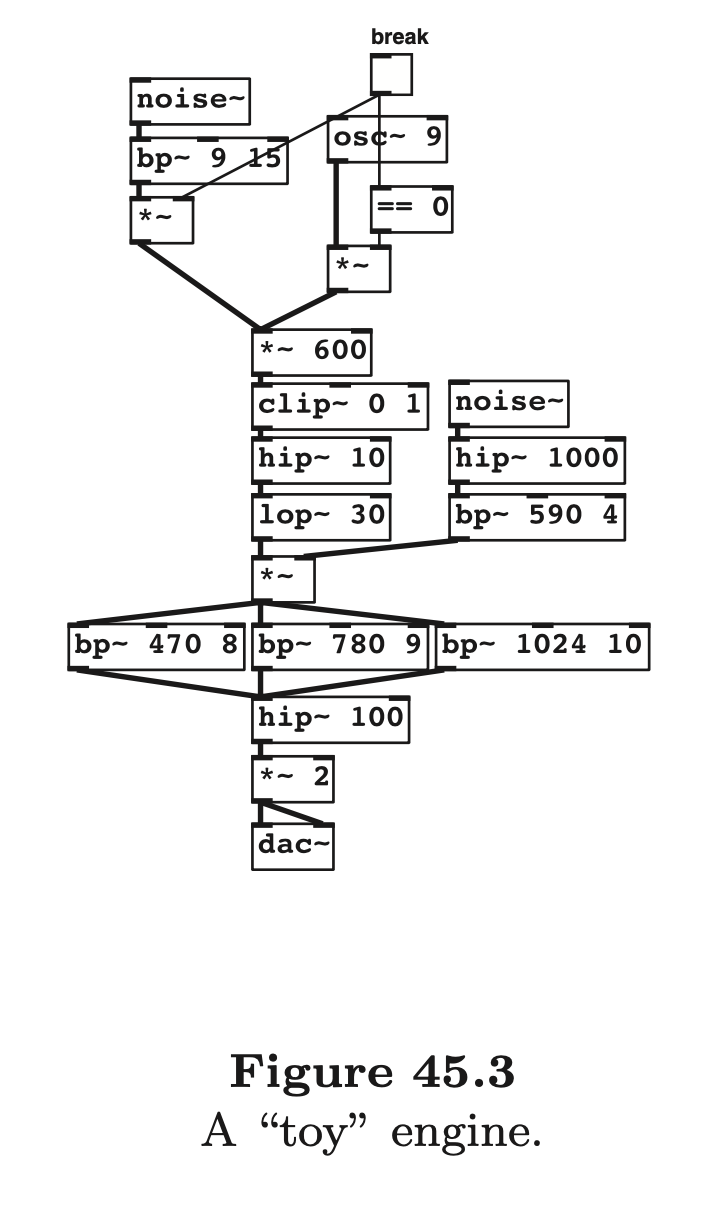

MaxMSP:

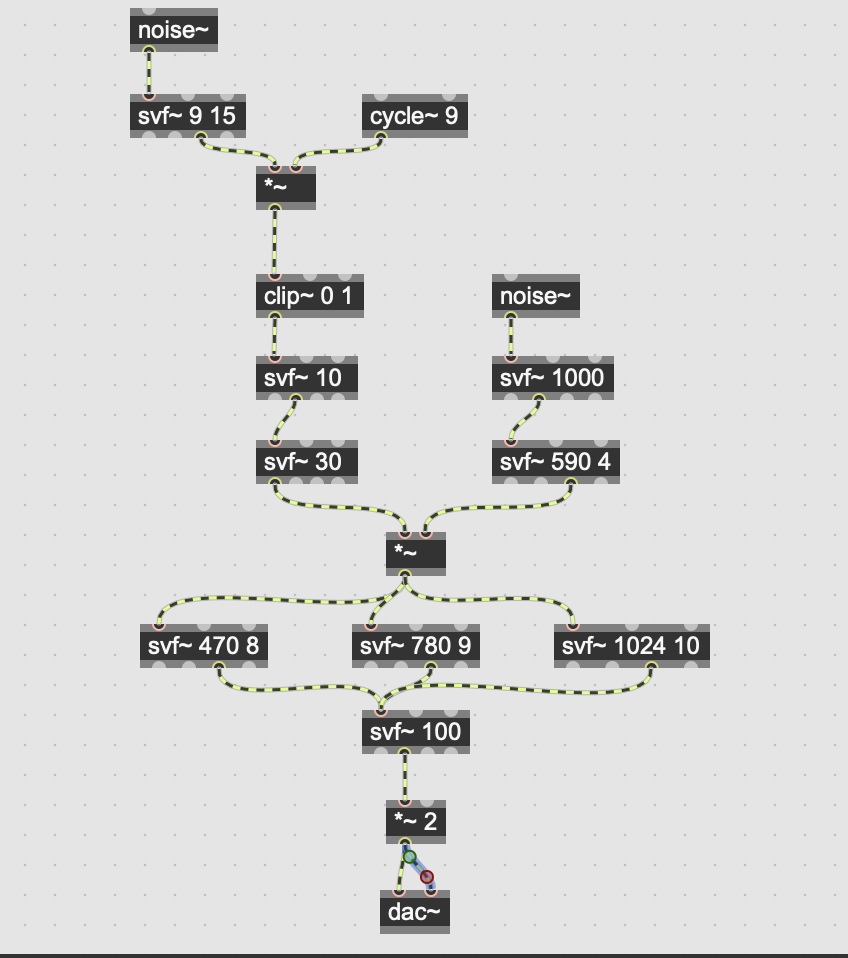

How Does This Code Work:
    
Farnell represents a rudimentary engine in his PureData code, including a piston, jitter, and an exhaust port. The top noise and 9Hz sine wave represent the piston, and switching between these two audio signals creates a faltering sound. Amplifying and then clipping creates a square wave, which is then put through a series of filters that behave like the exhaust valve closing and stopping the exhaust system. The parallel bandpass filters create some clonky sounds to add to the engine noise.

Python Implementation:

This code was translated almost verbatum from the MaxMSP code above. The only change was to use a bandpass filter instead of a highpass filter and then a lowpass filter for hp_10 and lp_30. The highpass filter worked fine, but once I ran it through the lowpass filter, I got no sound from it. Logically a bandpass filter that grabs frequencies between 10 and 30 is the same as applying a highpass filter for 10Hz and then a lowpass filter for 30Hz (and vice versa). Sound-wise, however, using a bandpass filter is not really the same - the order of filters applied does matter, and the logic does not represent that - but I was able to get a closer sound to the original by using the bandpass filter instead, so I made that change. 

I also added a graph to show the square waves that amplifying and then clipping creates.

In [ ]:
def run_toy_engine(duration, srate=44100):
    dur = duration*srate
    noise = (2 * np.random.random((dur))) -1
    bp_9_15 = band_pass(noise, 9, 15, srate)
    osc_9 = sinusoid(freq=9, dur=duration)
    star_squiggle_600 = (bp_9_15 * osc_9)
    
    clip_0_1 = np.clip(star_squiggle_600, 0, 1) 
    fig, ax = plot.subplots(figsize=(4,3)) 
    plot.plot(clip_0_1[0:1000])
    plot.title("Square Waves")
    plot.show()
    hp_10_lp_30 = band_pass(clip_0_1, 20, 10, srate)
    noise = (2 * np.random.random((dur))) -1
    hp_1000 = hi_pass(noise, 1000, srate)
    bp_590_4 = band_pass(hp_1000, 590, 4, srate)
    star_squiggle = (hp_10_lp_30 * bp_590_4)
    
    bp_470_8 = band_pass(star_squiggle, 470, 8, srate)
    bp_780_9 = band_pass(star_squiggle, 780, 9, srate)
    bp_1024_10 = band_pass(star_squiggle, 1024, 10, srate)
    
    hp_100_add = bp_470_8 + bp_780_9 + bp_1024_10
    hp_100 = hi_pass(hp_100_add, 100, srate)
    star_squiggle_2 = hp_100 * 2
    return star_squiggle_2

audio = run_toy_engine(5)

Python Toy Engine Audio:

In [ ]:
ipd.Audio(audio,rate=srate)

MaxMSP Toy Engine Audio:

In [ ]:
rate, data = wav.read("MaxMSP_car_engine.wav")
#convert to mono
data = [s[0] for s in data]
ipd.Audio(data,rate=rate)

MaxMSP Audio VS Python Audio:

The two audios sound relatively similar, however, the python audio sounds a tiny bit deeper than the MaxMSP audio, and I would argue that the deeper sound actually sounds more like an engine than the higher sound. The python audio also has a grainy noise that sounds like the rumbling of an engine, versus the MaxMSP audio whose graininess sounds closer to static. All in all, this was a success.

FOUR-STROKE ENGINE:

Lastly, I tackled Farnell's implmentation of the four-stroke engine. There are quite a few changes I made that effect the sound, but can be implemented later. I removed all the delays because MaxMSP does not have the same type of delays and I did not want to spend time working out delays - I just wanted to see if recreating any part of the PureData code made an engine sound. I also put all the patches together in one patch so I could see all the code at once and the code didn't need to bounce around.


PureData:
 
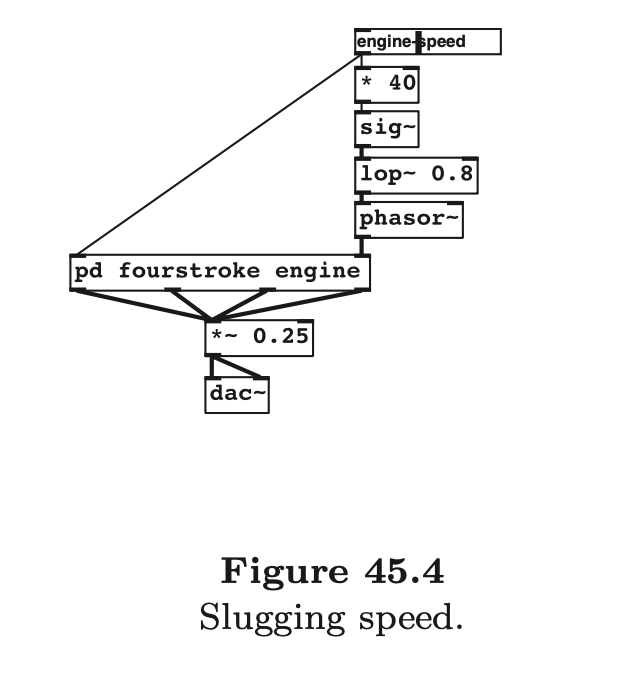

 

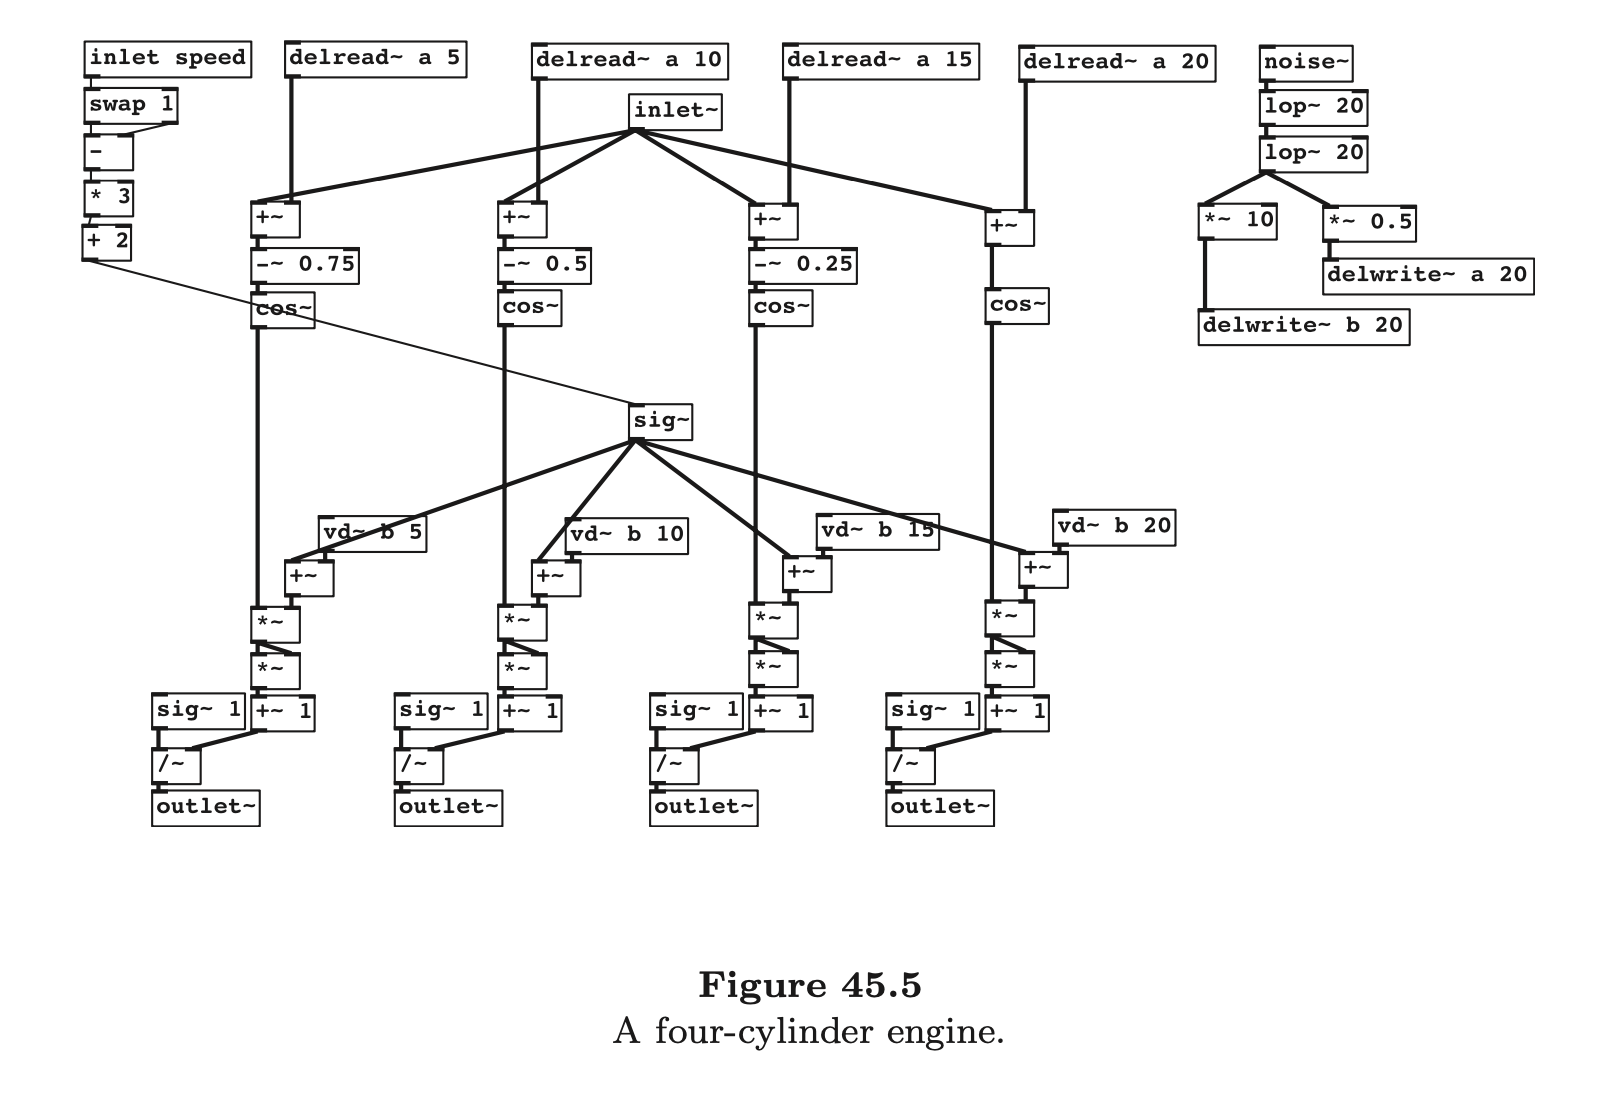

MaxMSP:
    
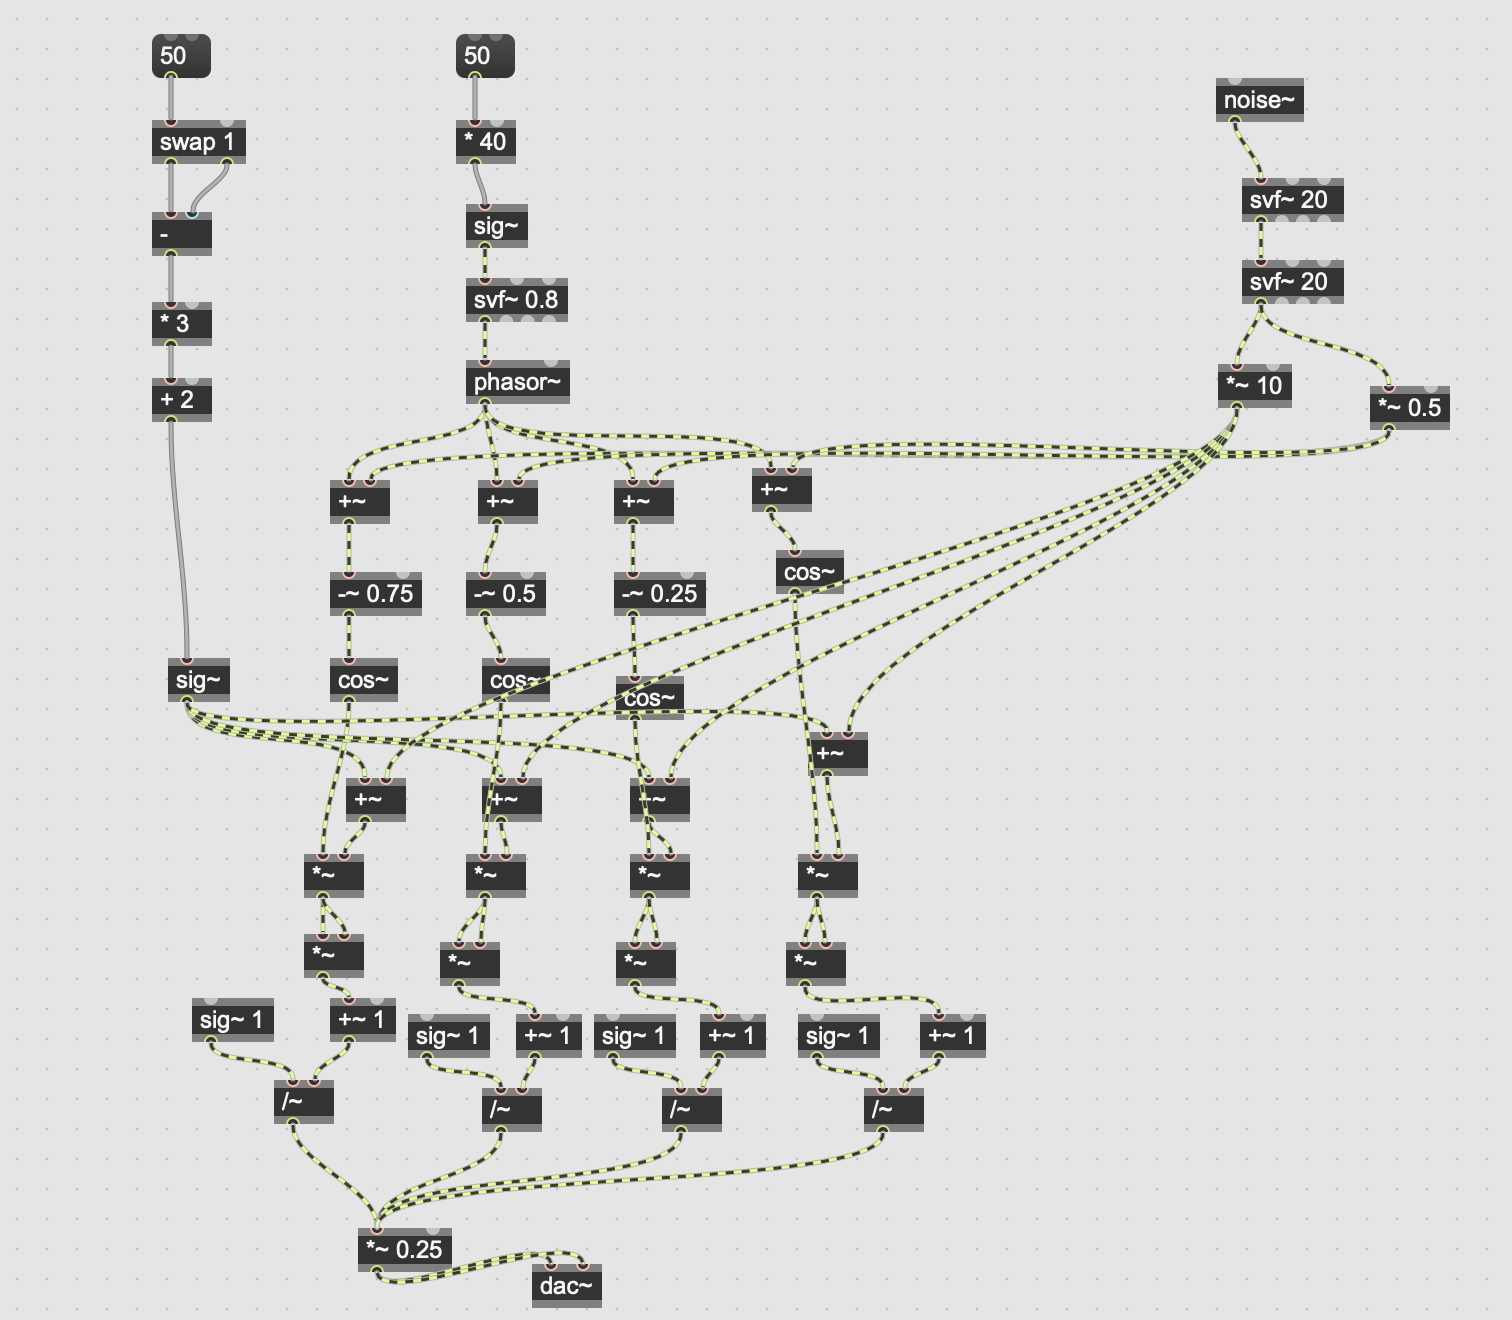

How Does This Code Work:

Each column coming off the phasor acts as a piston with the crankshaft rotating on phases 0.25 off from the next and previous pistons. This simulates how a car engine's cylinders create a round (like row, row, row your boat) by shifting the rotations for a smoother ride. The engine is driven by an external phasor and putting the phasor thorugh a low_pass filter creates the effect of inertia, which is the limit of the speed up and slow down of an engine. If an engine speeds up or slows down too fast, the audio will sound off and we can replicate that with the phasor.

The cylinders themselves are almost all the same with the pulse for each cylinder obtained by using a 1/(1 + kx^2) shaper. Then we obtain four cosinusoidal phases from the same phasor by subtracting 0.75 (3/4 of a cycle for the first cylinder), then 0.5 (1/2 of a cycle for the second cylinder), 0.25 (1/4 of a cycle for the third cylinder), and finally no subtraction for the last cylinder and then taking the cosine of these shifted signals.

The noise source in the top right ceates jitter. In the PureData code, the noise source is fed to two delay lines spaced 5ms apart to produce the effect of a fuel and air stream that feeds each cylinder in succession. The MaxMSP translation does not have the delays but it still produces jitter that is copied across the cylinders, one line adds noise to the pulse width and the other adds noise to the ignition timing.

Python Implementation:

The python version is very different when it comes to the phasor. In MaxMSP's documentation, a phasor is a sawtooth wave that acts as a control on the amplitude and frequency of a signal. I added my samples to the phasor (sawtooth wave) to replicate the phasor of MaxMSP and I even added a graph to show the sawtooth wave phasor. However, this sawtooth implementation created a harsh clipping noise that I could not reduce even with filters. The phasor code has been commented out and the phasor audio has been removed entirely from the audio. Implementing a better phasor method is a must for future work. 

In [ ]:
def run_four_stroke_engine(duration, speed, srate=44100):
    # delwrite
    dur = duration*srate
    noise = (2 * np.random.random((dur))) -1
    lp_20 = lo_pass(noise, 20, srate)
    lp_20 = lp_20[:dur]
    lp_20_dup = lo_pass(lp_20,20, srate)
    lp_20_dup = lp_20_dup[:dur]

    star_squiggle_10 = lp_20_dup * 10
    star_squiggle_05 = lp_20_dup * 0.5
    
    # inlet speed
    swap = ((1 - speed)*3)+2
    sig_inlet = np.full(dur, swap, dtype=int)
    
    # engine speed
    engine_speed = speed * 40
    sig_engine = np.full(dur, engine_speed, dtype=int)
    lp_08 = lo_pass(sig_engine, 0.8, srate) 
    lp_08 = lp_08[:dur]
#     t = np.linspace(0,1,int(srate*duration))
#     phasor = signal.sawtooth(2 * np.pi * 30 * lp_08)  
#     return phasor
#     fig, ax = plot.subplots(figsize=(4,3)) 
#     plot.plot(phasor)
#     plot.title("Sawtooth Waves")
#     plot.show()
    
    sig_1_reused = np.full(dur, 1, dtype=int)
    
    # piston 1
#     inlet_1 = star_squiggle_05 + phasor
#     minus_squiggle_075 = inlet_1 - 0.75
    minus_squiggle_075 = star_squiggle_05 - 0.75
    cos_1 = np.cos(minus_squiggle_075)
    plus_squiggle_1 = star_squiggle_10 + sig_inlet
    star_squiggle_1 = cos_1 * plus_squiggle_1
    star_squiggle_double_1 = star_squiggle_1 * star_squiggle_1
    divide_squiggle_1 = sig_1_reused/(star_squiggle_double_1+1)
    star_squiggle_025 = divide_squiggle_1 * 0.25

    # piston 2
#     inlet_2 = star_squiggle_05 + phasor
#     minus_squiggle_05 = inlet_2 - 0.5
    minus_squiggle_05 = star_squiggle_05 - 0.5
    cos_2 = np.cos(minus_squiggle_05)
    plus_squiggle_2 = star_squiggle_10 + sig_inlet
    star_squiggle_2 = cos_1 * plus_squiggle_2
    star_squiggle_double_2 = star_squiggle_2 * star_squiggle_2
    divide_squiggle_2 = sig_1_reused/(star_squiggle_double_2+1)
    
    # piston 3
#     inlet_3 = star_squiggle_05 + phasor
#     minus_squiggle_025 = inlet_2 - 0.25
    minus_squiggle_025 = star_squiggle_05 - 0.25
    cos_3 = np.cos(minus_squiggle_025)
    plus_squiggle_3 = star_squiggle_10 + sig_inlet
    star_squiggle_3 = cos_3 * plus_squiggle_3
    star_squiggle_double_3 = star_squiggle_3 * star_squiggle_3
    divide_squiggle_3 = sig_1_reused/(star_squiggle_double_3+1)
    
    # piston 4
#     inlet_4 = star_squiggle_05 + phasor
    cos_4 = np.cos(star_squiggle_05)
    plus_squiggle_4 = star_squiggle_10 + sig_inlet
    star_squiggle_4 = cos_4 * plus_squiggle_4
    star_squiggle_double_4 = star_squiggle_4 * star_squiggle_4
    divide_squiggle_4 = sig_1_reused/(star_squiggle_double_4+1)
    
    pistons = (divide_squiggle_1 * divide_squiggle_2 * divide_squiggle_3 * divide_squiggle_4) *0.25
    return pistons


Python Four-Stroke Engine Audio:

In [ ]:
srate = 44100
audio = run_four_stroke_engine(5, 50)
ipd.Audio(audio,rate=srate)

MaxMSP Four-Stroke Engine Audio:
    
This audio is very quiet/low and you will probably need to turn up your volume almost all the way to hear it.

In [ ]:
rate, data = wav.read("MaxMSP_four_stroke.wav")
#convert to mono
data = [s[0] for s in data]
ipd.Audio(data,rate=rate)

MaxMSP Audio VS Python Audio:
    
The audio of the four-stroke engines are very different in MaxMSP versus python. The MaxMSP audio is deeper and has a rumbling background noise. The python audio also has that background rumbling, but it still has some higher random noise. This method was a partial success, but the phasor needs work and the delays should be put in.

CONCLUSIONS:

Car engine physical modelling is difficult, because it involves sounds from so many different aspects of the engine. The basic engines that Farnell created in PureData do a great job at creating car engine audio based on the physical componenets of the engine that make sound. I wanted to see if translating from MaxMSP to python verbatum would work in order to keep the physically modelled aspects of the engine, and there were areas that worked wonderfully and areas that didn't. In particular, the piston representation and the jitter from noise waves worked very well for physical modelling, and those methods should be used synthesizing engine audio. I would definitely recommend Farnell's implementations as starting points for the physcial modelling of car engines.